# Motivations
* Whether our model could update FE such that the updated weights could predict similar activation map as in pretrained VGG19?

In [4]:
import torch
from models.new_model import FeatureExtractor
from torch.utils.data.dataloader import DataLoader
from dataset import dataloader

In [2]:
# load our weights to VGG-19
FE = FeatureExtractor().cuda()
ckp = torch.load("toy-model_9_epoch.pth")
FE.load_state_dict(ckp['FE_state_dict'])

/home/qiwang/anaconda3/envs/ven/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/qiwang/anaconda3/envs/ven/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [6]:
dst = dataloader(root='/big_data/qi1/Celeba/train', hr_shape=64)
img = DataLoader(dst, batch_size=16,shuffle=True,)

In [9]:
_,im = next(enumerate(img))

In [23]:
im['hr'].shape

torch.Size([16, 3, 64, 64])

In [15]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

### Activation maps

In [78]:
from torchvision.models import vgg19

In [79]:
VGG19 = vgg19(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/qiwang/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [99]:
VGG19 = VGG19.cuda()
ls_vgg19 = list(VGG19.named_modules())

In [113]:
norm = lambda x : (x-x.mean())/x.std()

In [122]:
grid_pre, grid_act, grid_empty = map(norm,[grid_pre, grid_act, grid_empty])
[print("max:%.3f\tmin:%.3f\tmean:%.3f"%(x.max(), x.min(), x.mean())) for x in [grid_pre, grid_act, grid_empty]]

max:9.979	min:-8.961	mean:-0.000
max:5.018	min:-4.861	mean:0.000
max:4.748	min:-4.705	mean:0.000


[None, None, None]

(-0.5, 529.5, 133.5, -0.5)

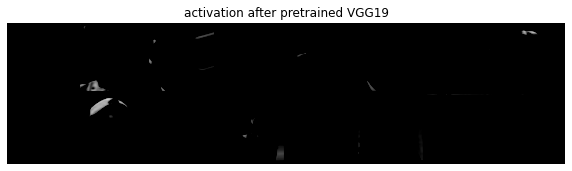

In [121]:
res_VGG19 = VGG19.features[0](im['hr'].cuda())
grid_pre = make_grid(res_VGG19)
plt.figure(figsize=(10,20))
plt.imshow(grid_pre[0].cpu().numpy(),vmin=0,cmap='gray')
plt.title("activation after pretrained VGG19")
plt.axis('off')

In [44]:
# infer image through FE with our trained weights
ls = list(FE.vgg19_54.named_modules())

In [48]:
ls[0][1][0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [49]:
res = ls[0][1][0](im['hr'].cuda())

In [51]:
grid_act = make_grid(res)

(-0.5, 529.5, 133.5, -0.5)

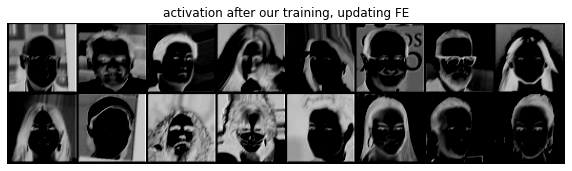

In [118]:
plt.figure(figsize=(10,20))
plt.imshow(grid_act[0].cpu().numpy(),vmin=0,cmap='gray')
plt.title("activation after our training, updating FE")
plt.axis('off')

In [56]:
# infer image through empty weights of FE
FE_empty = FeatureExtractor().cuda()
ls_empty = list(FE_empty.vgg19_54.named_modules())

res_empty = ls_empty[0][1][0](im['hr'].cuda())
grid_empty = make_grid(res_empty)

/home/qiwang/anaconda3/envs/ven/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/qiwang/anaconda3/envs/ven/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


(-0.5, 529.5, 133.5, -0.5)

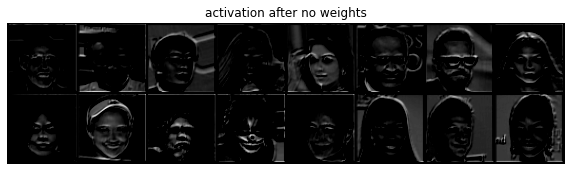

In [75]:
plt.figure(figsize=(10,20))
plt.imshow(grid_empty[0].cpu().numpy(),vmin=0,cmap='gray')
plt.title("activation after no weights")
plt.axis('off')

### Tried to visualize Kernels, while not distinguishible

In [65]:
ls_param = list(FE.parameters())
grid = make_grid(ls_param[0])

In [66]:
ls_param_empty = list(FE_empty.parameters())
grid_kernel_empty = make_grid(ls_param_empty[0])

## Empirical spectral density(ESD) --- the eigenvalues of layers

In [132]:
# weights of first Conv1
list(VGG19.features.parameters())[0].shape

torch.Size([64, 3, 3, 3])

In [133]:
weights_pre = list(VGG19.features.parameters())[0]

In [134]:
weights_empty = list(FE_empty.parameters())[0]

In [178]:
weights_ours = list(FE.parameters())[0]

In [136]:
eigv_pre = torch.linalg.eigvals(weights_pre)

In [137]:
eigv_empty = torch.linalg.eigvals(weights_empty)

In [179]:
eigv_ours = torch.linalg.eigvals(weights_ours)

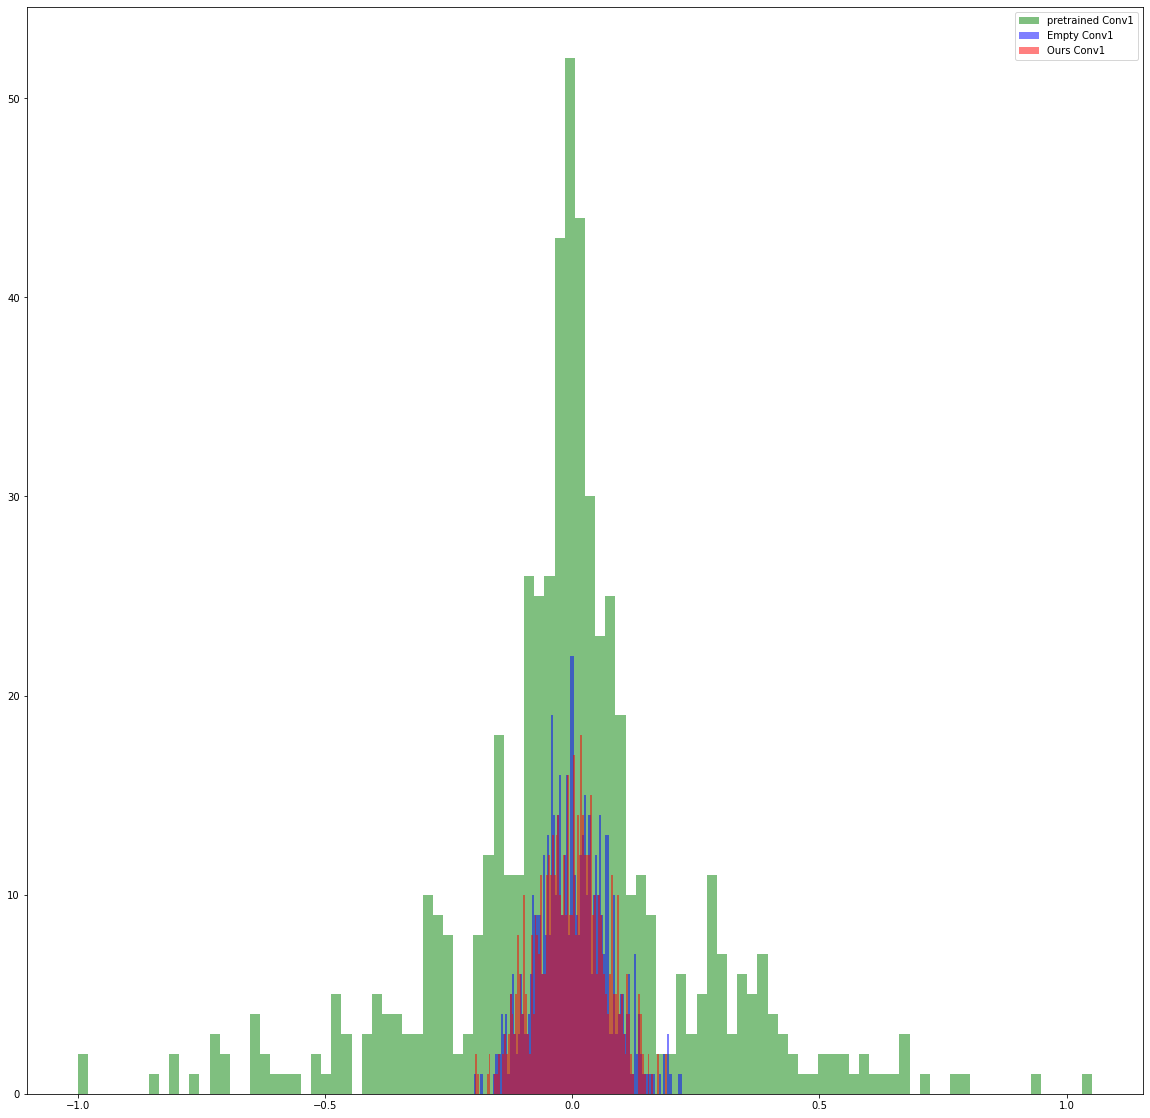

In [181]:
plt.figure(figsize=(20,20))
plt.hist(eigv_pre.real.detach().flatten().cpu().numpy(),bins=100,color='green',alpha=0.5,label='pretrained Conv1')
plt.hist(eigv_empty.real.detach().flatten().cpu().numpy(),bins=100,color='blue',alpha=0.5,label='Empty Conv1')
plt.hist(eigv_ours.real.detach().flatten().cpu().numpy(),bins=100,color='red',alpha=0.5,label='Ours Conv1')
plt.legend()